## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest 

In [128]:
df = pd.read_csv('ab_test_ensembles.csv')

df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [130]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [131]:
df_clean = df[
    ((df['group'] == 'control') & (df['variants'] == 'standard')) | 
    ((df['group'] == 'treatment') & (df['variants'] == 'svm_ensemble_v_1_22'))
]

In [132]:
df_clean

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
...,...,...,...,...,...,...,...,...
294473,497bf0f8-0092-4736-8ae7-775b6cc9736c,2022-05-03 22:28:38.630509,control,standard,0,United Kingdom,58+,new_user
294474,6cb20e62-e49d-41cf-97da-0e11cb439dca,2022-05-12 00:51:57.078372,control,standard,0,United Kingdom,42-49,new_user
294475,d307b0ad-92a1-409c-a2d2-da8f4a118576,2022-05-22 11:45:03.439544,control,standard,0,United Kingdom,18-25,registered_user
294476,c6bd8da5-2114-4fd4-92c6-e4b11a8be4dc,2022-05-15 01:20:28.957438,control,standard,0,United Kingdom,50-57,new_user


In [133]:
print(f"Удалено некорректных записей: {df.shape[0] - df_clean.shape[0]}")

Удалено некорректных записей: 3893


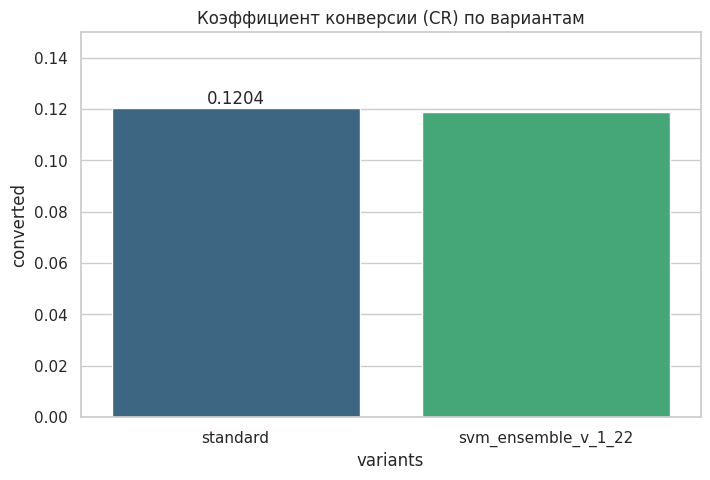

In [134]:

plot_data = df_clean.groupby('variants', as_index=False)['converted'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=plot_data, x='variants', y='converted', palette='viridis', ax=ax, hue='variants', dodge=False)
ax.set_title('Коэффициент конверсии (CR) по вариантам')
ax.set_ylim(0, 0.15)
ax.bar_label(ax.containers[0], fmt='%.4f')

plt.show()

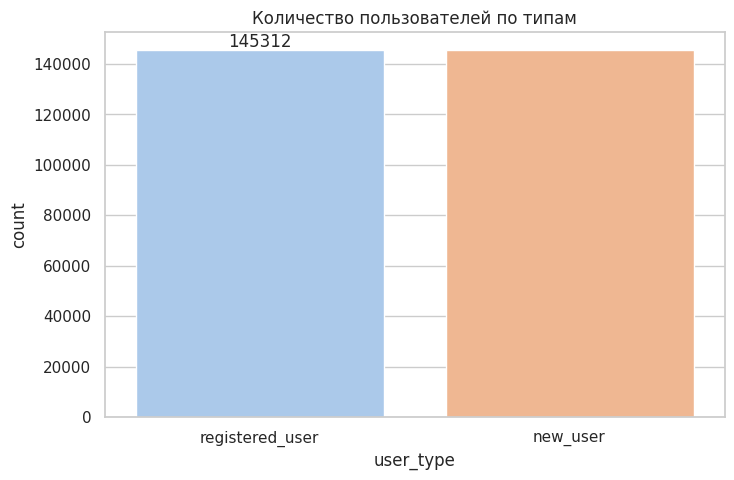

In [135]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df_clean, x='user_type', palette='pastel', ax=ax, hue='user_type', dodge=False)
ax.set_title('Количество пользователей по типам')
ax.bar_label(ax.containers[0])

plt.show()

In [136]:
ab_summary = df_clean.groupby('variants').agg(
    users=('user_id', 'count'),
    conversions=('converted', 'sum')
)

ab_summary['conversion_rate'] = ab_summary['conversions'] / ab_summary['users']


conv_control = ab_summary.loc['standard', 'conversions']
nobs_control = ab_summary.loc['standard', 'users']
cr_control = ab_summary.loc['standard', 'conversion_rate']

conv_treat = ab_summary.loc['svm_ensemble_v_1_22', 'conversions']
nobs_treat = ab_summary.loc['svm_ensemble_v_1_22', 'users']
cr_treat = ab_summary.loc['svm_ensemble_v_1_22', 'conversion_rate']


In [137]:
uplift = (cr_treat - cr_control) / cr_control

print(f"CR Control (Standard): {cr_control}")
print(f"CR Treatment (SVM): {cr_treat}")
print(f"Uplift: {uplift}")

conversions = [conv_control, conv_treat]
nobs = [nobs_control, nobs_treat]

z_stat, p_value = proportions_ztest(count=conversions, nobs=nobs)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value:     {p_value:.4f}")

if p_value < 0.05:
    print("Различи статистически значимо (p < 0.05)")
else:
    print("Различие не статистически значимо (p >= 0.05)")


CR Control (Standard): 0.1203863045004612
CR Treatment (SVM): 0.11880724790277405
Uplift: -0.0131165800315857
Z-statistic: 1.3116
P-value:     0.1897
Различие не статистически значимо (p >= 0.05)


In [138]:
def check_segment(df, user_type):
    segment_df = df[df['user_type'] == user_type]
    
    stats = segment_df.groupby('variants').agg(
        users=('user_id', 'count'),
        converted=('converted', 'sum')
    )
    
    n_ctrl = stats.loc['standard', 'users']
    conv_ctrl = stats.loc['standard', 'converted']
    cr_ctrl = conv_ctrl / n_ctrl
    
    n_treat = stats.loc['svm_ensemble_v_1_22', 'users']
    conv_treat = stats.loc['svm_ensemble_v_1_22', 'converted']
    cr_treat = conv_treat / n_treat
    
    uplift = (cr_treat - cr_ctrl) / cr_ctrl
    
    z_stat, p_val = proportions_ztest(
        count=[conv_treat, conv_ctrl],
        nobs=[n_treat, n_ctrl],
        alternative='larger'
    )
    
    return {
        'segment': user_type,
        'CR Control': f"{cr_ctrl:.2%}",
        'CR Treatment': f"{cr_treat:.2%}",
        'Uplift': f"{uplift:.2%}",
        'P-value': round(p_val, 4),
        'Decision': 'статистически значимо' if p_val < 0.05 and uplift >= 0.02 else 'Различие не статистически значимо'
    }

res_new = check_segment(df_clean, 'new_user')
res_reg = check_segment(df_clean, 'registered_user')

pd.DataFrame([res_new, res_reg])

,segment,CR Control,CR Treatment,Uplift,P-value,Decision
0,new_user,12.09%,11.73%,-2.95%,0.9821,Различие не статистически значимо
1,registered_user,11.99%,12.03%,0.34%,0.4061,Различие не статистически значимо


На основании анализа всей выборки из 200k+ записей, вариант svm_ensemble_v_1_22 не показал улучшения коэффициента конверсии по сравнению с текущим standard: общий Uplift составил -1,3%, а различие статистически незначимо (p = 0,1897). Аналогичная картина наблюдается при разбиении по типам пользователей: для новых пользователей Treatment хуже Control (-2,95%, p = 0,9821), а для зарегистрированных разница минимальна и незначима (+0,34%, p = 0,4061).

Следовательно, внедрение нового варианта нецелесообразно, и следует оставить текущий вариант работы standard как для всей аудитории, так и для отдельных сегментов пользователей.